In [13]:
!pip install gensim==3.8.3

Found existing installation: gensim 4.1.2
Uninstalling gensim-4.1.2:
  Would remove:
    /opt/conda/lib/python3.9/site-packages/gensim-4.1.2.dist-info/*
    /opt/conda/lib/python3.9/site-packages/gensim/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
     |████████████████████████████████| 23.4 MB 7.6 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24328218 sha256=7414a04bce75ccb82137db4ba90cfd00acdd6a7ea76d3f4289b0ad5cef3e9fe5
  Stored in directory: /aiffel/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2


In [3]:
#pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 KB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp39-cp39-linux_x86_64.whl size=326474 sha256=6576650fe0beb265987415ddf8b23f769fb1a6f44dfce6a06e193f026d3351a9
  Stored in directory: /aiffel/.cache/pip/wheels/e1/b9/f8/9caac00aff8e25c0d13fa29fd7f05618b3a9f6bb2f60278023
Successfully built fasttext
Note: you may need to restart the kernel to use updated packages.


In [5]:
"""from gensim.models import Word2Vec

# Gensim 3.x에서는 정상 로드됨
model = Word2Vec.load("./data/ko.bin")

# Word2Vec text/binary 포맷으로 저장 (Gensim 4.x와 호환 가능)
model.wv.save_word2vec_format("ko.vec", binary=False)"""

'from gensim.models import Word2Vec\n\n# Gensim 3.x에서는 정상 로드됨\nmodel = Word2Vec.load("./data/ko.bin")\n\n# Word2Vec text/binary 포맷으로 저장 (Gensim 4.x와 호환 가능)\nmodel.wv.save_word2vec_format("ko.vec", binary=False)'

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import gensim

print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(nltk.__version__)
print(gensim.__version__)

import re
from konlpy.tag import Mecab
import fasttext
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

1.21.4
1.3.3
2.6.0
3.6.5
3.8.3


In [2]:
import matplotlib.font_manager as fm
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # 또는 'AppleGothic', 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 설정 확인
print(plt.rcParams['font.family'])

['NanumGothic']


In [3]:
file_path = "./data/ChatbotData.csv"

chatbot_df = pd.read_csv(file_path)

chatbot_df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
chatbot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


### 시행착오 1
validation과 test를 나누어서 훈련의 양상을 보려고 시도했지만,

validation loss가 크게 줄어들지 않고, 줄어든다고 해도 과적합인지를 확정짓기에는 어려움이 있을 것 같아서

train data만 사용하는 방식으로 진행해봄.

In [5]:
from sklearn.model_selection import train_test_split
train_df = chatbot_df
#train_val_df, test_df = train_test_split(chatbot_df, test_size=0.05, random_state=42)
#train_df, val_df = train_test_split(train_val_df, test_size=10, random_state=42)

In [6]:
questions, answers = train_df['Q'], train_df['A']
#test_q, test_a =  test_df['Q'], test_df['A']
#val_q, val_a =  val_df['Q'], val_df['A']

### 데이터 전처리

데이터 분포를 확인해 본 결과, token의 개수가 15개일 때 상위 95%의 데이터를 포함할 수 있어서

15개의 토큰이 최대가 되도록 필터링하였습니다.

In [7]:
def preprocess_sentence(sentence):
    # 영문자의 경우, 모두 소문자로 변환합니다.
    sentence = sentence.lower()
    
    # 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.
    sentence = re.sub(r"[^a-z0-9가-힣\s.,!?'\-]", "", sentence)
    
    return ' '.join(sentence.split())

In [8]:
mecab = Mecab()

def build_corpus(Q, A, is_train=True):
    token_len = 15
    percentile = 95

    temp = pd.concat([Q,A], axis=1)
    
    # 중복제거
    temp = temp.drop_duplicates('Q') # Q에서 중복있으면 삭제
    temp = temp.drop_duplicates('A') # A에서 중복있으면 삭제
    
    # preprocess
    temp['Q'] = temp['Q'].apply(preprocess_sentence)
    temp['A'] = temp['A'].apply(preprocess_sentence)
    
    if is_train:
        #mecab 사용 형태소 제거
        temp['Q'] = temp['Q'].apply(lambda x: mecab.pos(x))
        temp['A'] = temp['A'].apply(lambda x: mecab.pos(x))
    else:
        temp['Q'] = temp['Q'].apply(lambda x: mecab.morphs(x))
        temp['A'] = temp['A'].apply(lambda x: mecab.morphs(x))
    
    # 길이 계산
    temp['Q_len'] = temp['Q'].apply(len)
    temp['A_len'] = temp['A'].apply(len)
    
    # 퍼센타일 기준 커트라인 계산
    q_threshold = np.percentile(temp['Q_len'], percentile)
    a_threshold = np.percentile(temp['A_len'], percentile)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    sns.histplot(temp['Q_len'], bins=30, kde=True, color='blue', label='Q')
    sns.histplot(temp['A_len'], bins=30, kde=True, color='green', label='A')
    plt.axvline(q_threshold, color='red', linestyle='--', label=f'Q {percentile}% cutoff = {q_threshold:.1f}')
    plt.axvline(a_threshold, color='orange', linestyle='--', label=f'A {percentile}% cutoff = {a_threshold:.1f}')
    plt.title(f"형태소 토큰 길이 분포 및 {percentile}% 커트라인")
    plt.xlabel("토큰 개수")
    plt.ylabel("문장 수")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    if token_len is not None:
        temp = temp[(temp['Q'].apply(len) < token_len) & (temp['A'].apply(len) < token_len)]
        
    return temp['Q'], temp['A']

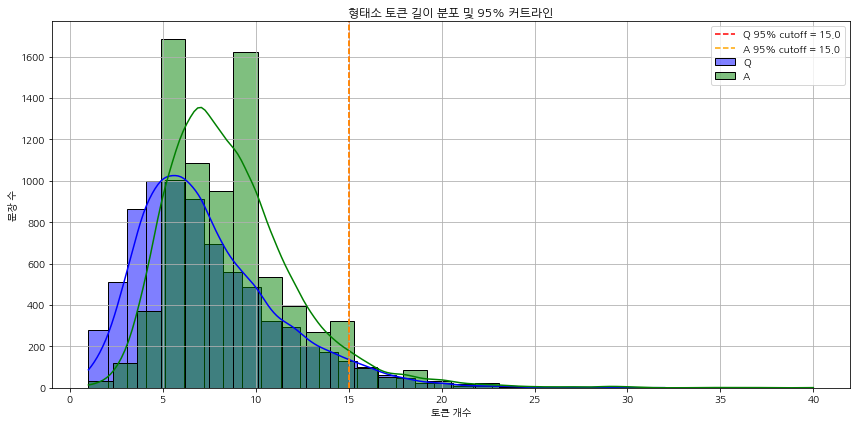

In [9]:
que_corpus, ans_corpus = build_corpus(questions, answers)

In [10]:
"""test_que_corpus, test_ans_corpus = build_corpus(test_q, test_a, is_train=False)
test_df = pd.concat([test_que_corpus, test_ans_corpus], axis=1).reset_index(drop=True)

val_que_corpus, val_ans_corpus = build_corpus(val_q, val_a, is_train=False)
val_df = pd.concat([val_que_corpus, val_ans_corpus], axis=1).reset_index(drop=True)"""

'test_que_corpus, test_ans_corpus = build_corpus(test_q, test_a, is_train=False)\ntest_df = pd.concat([test_que_corpus, test_ans_corpus], axis=1).reset_index(drop=True)\n\nval_que_corpus, val_ans_corpus = build_corpus(val_q, val_a, is_train=False)\nval_df = pd.concat([val_que_corpus, val_ans_corpus], axis=1).reset_index(drop=True)'

In [11]:
que_corpus

0                 [(12, SN), (시, NNBC), (땡, MAG), (!, SF)]
1        [(1, SN), (지망, NNG), (학교, NNG), (떨어졌, VV+EP), ...
2        [(3, SN), (박, NNBC), (4, SN), (일, NNBC), (놀, V...
4                           [(ppl, SL), (심하, VA), (네, EC)]
5             [(sd, SL), (카드, NNG), (망가졌, VV+EP), (어, EC)]
                               ...                        
11814    [(회사, NNG), (에서, JKB), (어떤, MM), (사람, NNG), (이...
11817    [(후회, NNG), (없이, MAG), (사랑, NNG), (하, XSV), (고...
11818    [(훔쳐, VV+EC), (보, VX), (는, ETM), (것, NNB), (도,...
11820    [(흑기사, NNG), (해, VV+EC), (주, VX), (는, ETM), (짝...
11821    [(힘든, VA+ETM), (연애, NNG), (좋, VA), (은, ETM), (...
Name: Q, Length: 6884, dtype: object

In [12]:
#test_df

In [13]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format("ko.vec", binary=False)
print(wv.most_similar("사랑"))

[('슬픔', 0.7216662764549255), ('행복', 0.6759077310562134), ('절망', 0.6468985080718994), ('기쁨', 0.6458414196968079), ('이별', 0.6334798336029053), ('추억', 0.6320937275886536), ('인생', 0.6216273307800293), ('애정', 0.6206069588661194), ('연인', 0.6186063289642334), ('유혹', 0.5965287685394287)]


### 시행착오 2

word2vector의 most similar를 사용해 단어를 교체하는 방법을 사용했습니다.

모든 토큰에 단어 교체를 사용할 수는 없었기에, mecab.pos를 사용하여 형태소를 받아오고,

특정 형태소(고유명사, 동사, 형용사, 대명사, 일반명사)만 바꿔가면서 자연스럽게 변환되는 형태소 조합을 찾아내었습니다.

### 시행착오 3

most similar의 특징상, 한 형태소에서 다른 형태소로의 변환이 일어날 수 있는데,

같은 형태소의 변환만 필터링하여 사용했습니다.

In [15]:
def get_pos_filtered_similars(tok, pos, wv, mecab, topn=5, similarity_threshold=0.7):
    try:
        similar_list = wv.most_similar(tok, topn=topn)
        filtered = []
        for w, sim in similar_list:
            if sim < similarity_threshold:
                continue
            pos_tags = mecab.pos(w)
            # 가장 첫 토큰의 POS만 확인 (보통 단일 단어면 하나의 결과)
            if pos_tags and pos_tags[0][1] == pos:
                filtered.append(w)
        return filtered
    except:
        return []

In [16]:
import itertools
def lexical_sub(old_src, wv):
    topn = 5
    similarity_threshold = 0.7
    pos_tags=['NNP', 'VV', 'VA', 'NP', 'NNG']  # 고유명사, 동사, 형용사, 대명사, 일반명사
    # 후보 단어 추출
    candidates = [(i, tok) for i, (tok, pos) in enumerate(old_src)
                  if pos in pos_tags and tok in wv]

    # 원문 문자열
    original = [tok for tok, _ in old_src]

    # 후보 단어 위치 + 유사어 리스트 추출
    candidate_subs = []
    for i, (tok, pos) in enumerate(old_src):
        if pos in pos_tags and tok in wv:
            filtered = get_pos_filtered_similars(tok, pos, wv, mecab, topn, similarity_threshold)
            if filtered:
                candidate_subs.append((i, filtered))

    # 후보가 없으면 원문만 반환
    if not candidate_subs:
        return [original]

    # 각 후보 위치마다 가능한 치환 리스트를 구성
    # 예: [(3, ['A', 'B']), (5, ['X', 'Y'])] → 치환 조합: [ (A,X), (A,Y), (B,X), (B,Y) ]
    all_versions = []

    positions, replacements = zip(*candidate_subs)
    for combo in itertools.product(*replacements):  # 모든 조합 생성
        new_sent = original.copy()
        for idx, rep in zip(positions, combo):
            new_sent[idx] = rep
        all_versions.append(new_sent)

    # 원문 포함
    all_versions.insert(0, original)

    return all_versions

In [17]:
from itertools import product
def augment_pairwise_cross_product_df(enc_src, dec_tgt, wv):
    """
    enc_src, dec_tgt: 형태소+POS 리스트 (예: mecab.pos 결과들)
    반환값: 증강된 (encoder, decoder) 문장쌍을 담은 DataFrame
    """
    rows = []
    
    
    for enc_tokens, dec_tokens in zip(enc_src, dec_tgt):
        enc_augments = lexical_sub(enc_tokens, wv)
        dec_augments = lexical_sub(dec_tokens, wv)

        for enc_version, dec_version in product(enc_augments, dec_augments):
            rows.append({
                'encoder': ' '.join(enc_version),
                'decoder': ' '.join(dec_version)
            })

    return pd.DataFrame(rows)

In [18]:
#cross_augmented = augment_pairwise_cross_product(que_corpus, ans_corpus, wv)

aug_df = augment_pairwise_cross_product_df(que_corpus, ans_corpus, wv)
print(aug_df.head(40))
aug_df.info()

                        encoder                           decoder
0                      12 시 땡 !                     하루 가 또 가 네요 .
1                 1 지망 학교 떨어졌 어                       위로 해 드립니다 .
2                1 지망 학교의 떨어졌 어                       위로 해 드립니다 .
3                1 지망 강습소 떨어졌 어                       위로 해 드립니다 .
4              1 지망 중고등학교 떨어졌 어                       위로 해 드립니다 .
5               1 지망 전문학교 떨어졌 어                       위로 해 드립니다 .
6               1 지망 사립학교 떨어졌 어                       위로 해 드립니다 .
7           3 박 4 일 놀 러 가 고 싶 다                    여행 은 언제나 좋 죠 .
8                      ppl 심하 네                    눈살 이 찌푸려 지 죠 .
9                   sd 카드 망가졌 어              다시 새로 사 는 게 마음 편해요 .
10              sns 맞 팔 왜 안 하 지             잘 모르 고 있 을 수 도 있 어요 .
11  sns 시간 낭비 인 거 아 는데 매일 하 는 중                시간 을 정하 고 해 보 세요 .
12    sns 보 면 나 만 빼 고 다 행복 해 보여                   자랑 하 는 자리 니까요 .
13                      가끔 궁금 해                  그 사람 도 그럴 거 예요 .
14        

---
코드 FIX 된 부분 끝
---

In [19]:
def vectorize(tokens):
    tokens = '<start> '+tokens+ '<end>'
    return tokens
aug_df['decoder_se'] = aug_df['decoder'].apply(vectorize)
"""test_df['A'] = test_df['A'].apply(lambda x: ' '.join(x))
test_df['Q'] = test_df['Q'].apply(lambda x: ' '.join(x))
test_df['A'] = test_df['A'].apply(vectorize)

val_df['A'] = val_df['A'].apply(lambda x: ' '.join(x))
val_df['Q'] = val_df['Q'].apply(lambda x: ' '.join(x))
val_df['A'] = val_df['A'].apply(vectorize)"""

"test_df['A'] = test_df['A'].apply(lambda x: ' '.join(x))\ntest_df['Q'] = test_df['Q'].apply(lambda x: ' '.join(x))\ntest_df['A'] = test_df['A'].apply(vectorize)\n\nval_df['A'] = val_df['A'].apply(lambda x: ' '.join(x))\nval_df['Q'] = val_df['Q'].apply(lambda x: ' '.join(x))\nval_df['A'] = val_df['A'].apply(vectorize)"

In [20]:
aug_df['decoder_se']

0                        <start> 하루 가 또 가 네요 .<end>
1                          <start> 위로 해 드립니다 .<end>
2                          <start> 위로 해 드립니다 .<end>
3                          <start> 위로 해 드립니다 .<end>
4                          <start> 위로 해 드립니다 .<end>
                            ...                    
31344                 <start> 진심 으로 다가가 보 세요 .<end>
31345         <start> 티 가 나 니까 눈치 가 보이 는 거 죠 !<end>
31346                        <start> 설렜 겠 어요 .<end>
31347     <start> 잘 헤어질 수 있 는 사이 여부 인 거 같 아요 .<end>
31348    <start> 잘 헤어질 수 있 는 사이 여부 인 거 똑같 아요 .<end>
Name: decoder_se, Length: 31349, dtype: object

In [21]:
#test_df

### 시행착오 4

SentencePiece의 기본 model_type은 unigram인데,

한 단어가 글자 단위 subword로 나뉘는 경향이 발생해서 최대 vocab size가 ~3000으로 나왔습니다.

\['\<s>', '▁내', '일', '이', '▁또', '▁오', '네요', '.', '\</s>'\]

model_type을 bpe로 바꾸니 더 subword를 잘 나누는 느낌이었고, 최대 vocab size가 16000까지 나왔습니다.

\['\<s>', '▁내일', '이', '▁또', '▁오', '네요', '.', '\</s>'\]

In [112]:
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="ko-ko",
                       pad_id=0,   # pad token의 일련번호
                       bos_id=1,  # 문장의 시작을 의미하는 bos token(<s>)의 일련번호
                       eos_id=2,  # 문장의 끝을 의미하는 eos token(</s>)의 일련번호
                       unk_id=3):   # unk token의 일련번호
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus:
            if isinstance(row, list):
                sentence = ' '.join(row)
            else:
                sentence = str(row)
            f.write(sentence.strip() + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id=%d --bos_id=%d --eos_id=%d --unk_id=%d --character_coverage=1.0 --model_type=bpe'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

In [24]:
VOCAB_SIZE = 15000
tokenizer = generate_tokenizer(aug_df['encoder'].to_list() + aug_df['decoder_se'].to_list(), VOCAB_SIZE, 'ko-ko')
tokenizer.set_encode_extra_options("bos:eos")  # 문장 양 끝에 <s> , </s> 추가

True

In [25]:
print(tokenizer.EncodeAsPieces("내일이 또 오네요."))
print(tokenizer.EncodeAsIds("내일이 또 오네요."))

aug_df['tok_enc'] = aug_df['encoder'].apply(tokenizer.EncodeAsIds)
aug_df['tok_dec'] = aug_df['decoder_se'].apply(tokenizer.EncodeAsIds)
max_len_enc = max(aug_df['tok_enc'].apply(len))
max_len_dec = max(aug_df['tok_dec'].apply(len))
max_len = max(max_len_enc, max_len_dec)

['<s>', '▁내일', '이', '▁또', '▁오', '네요', '.', '</s>']
[1, 668, 13801, 222, 97, 11715, 13793, 2]


In [27]:
"""test_df['tok_enc'] = test_df['Q'].apply(tokenizer.EncodeAsIds)
test_df['tok_dec'] = test_df['A'].apply(tokenizer.EncodeAsIds)

val_df['tok_enc'] = val_df['Q'].apply(tokenizer.EncodeAsIds)
val_df['tok_dec'] = val_df['A'].apply(tokenizer.EncodeAsIds)"""

"test_df['tok_enc'] = test_df['Q'].apply(tokenizer.EncodeAsIds)\ntest_df['tok_dec'] = test_df['A'].apply(tokenizer.EncodeAsIds)\n\nval_df['tok_enc'] = val_df['Q'].apply(tokenizer.EncodeAsIds)\nval_df['tok_dec'] = val_df['A'].apply(tokenizer.EncodeAsIds)"

In [28]:
display(aug_df.head())
display(aug_df.iloc[1]['tok_dec'])

,encoder,decoder,decoder_se,tok_enc,tok_dec
0,12 시 땡 !,하루 가 또 가 네요 .,<start> 하루 가 또 가 네요 .<end>,"[1, 4468, 69, 1165, 170, 2]","[1, 7, 10, 13791, 659, 14, 222, 14, 70, 11, 9,..."
1,1 지망 학교 떨어졌 어,위로 해 드립니다 .,<start> 위로 해 드립니다 .<end>,"[1, 484, 4214, 821, 1897, 15, 2]","[1, 7, 10, 13791, 1797, 21, 1569, 11, 9, 13791..."
2,1 지망 학교의 떨어졌 어,위로 해 드립니다 .,<start> 위로 해 드립니다 .<end>,"[1, 484, 4214, 1216, 1897, 15, 2]","[1, 7, 10, 13791, 1797, 21, 1569, 11, 9, 13791..."
3,1 지망 강습소 떨어졌 어,위로 해 드립니다 .,<start> 위로 해 드립니다 .<end>,"[1, 484, 4214, 1213, 1897, 15, 2]","[1, 7, 10, 13791, 1797, 21, 1569, 11, 9, 13791..."
4,1 지망 중고등학교 떨어졌 어,위로 해 드립니다 .,<start> 위로 해 드립니다 .<end>,"[1, 484, 4214, 1220, 1897, 15, 2]","[1, 7, 10, 13791, 1797, 21, 1569, 11, 9, 13791..."


[1, 7, 10, 13791, 1797, 21, 1569, 11, 9, 13791, 2]

In [29]:
#display(test_df.head())
#display(test_df.iloc[1]['tok_dec'])

In [30]:
#display(val_df.head())
#display(val_df.iloc[1]['tok_dec'])

### 모델 만들기

In [31]:
def positional_encoding(pos, d_model):
    # TODO: 코드 구현
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])    

    return sinusoid_table

In [32]:
def generate_padding_mask(seq):
    # TODO: 구현
    # padding token을 마스크
    seq = tf.cast(tf.math.equal(seq,0), tf.float32)
    # broadcast가 가능하도록 4d로 확장
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    # TODO: 구현
    # (size, size) 정사각 행렬 중 상삼각 부분을 1.0으로 표시
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    # TODO: 구현
    """
    tgt shape : (batch_size, seq_len)
    """
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    # 두 마스크 중 하나라도 1이라면 마스킹
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [33]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        # TODO: 구현
        dk = tf.cast(K.shape[-1], tf.float32)
        scaled_QK = tf.matmul(Q, K, transpose_b=True)/tf.math.sqrt(dk)

        if mask is not None:
            scaled_QK += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_QK, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        
    def split_heads(self, x):
        # TODO: 구현
        """
        (batch, seq_len, emb_dim)
        -> (batch, num_heads, seq_len, depth)
        """

        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(x, perm=[0, 2, 1, 3])
        return split_x

    def combine_heads(self, x):
        # TODO: 구현

        batch_size = tf.shape(x)[0]
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(x, (batch_size, -1, self.num_heads*self.depth))

        return combined_x

    def call(self, Q, K, V, mask):
        # TODO: 구현
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        split_WQ = self.split_heads(WQ)
        split_WK = self.split_heads(WK)
        split_WV = self.split_heads(WV)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(split_WQ, split_WK, split_WV, mask)
        concat_attention = self.combine_heads(scaled_attention)
        out = self.linear(concat_attention)
        
        return out, attention_weights

In [34]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        # TODO: 구현
        x = self.fc1(x)
        out = self.fc2(x)

        return out

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        # TODO:  구현
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        '''
        Position-Wise Feed Forward Network
        '''
        # TODO: 구현
        risudual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):

        '''
        Masked Multi-Head Attention
        '''
        # TODO: 구현
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        # TODO: 구현
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        # TODO: 구현
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [37]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        # TODO: 구현

        enc_attns = list()
        for enc_layer in self.enc_layers:
            x, enc_attn = enc_layer(x, mask)
            enc_attns.append(enc_attn)

        return x, enc_attns

In [38]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        # TODO: 구현
        out = x
        dec_attns = []
        dec_enc_attns = []
        for dec_layer in self.dec_layers:
            out, dec_attn, dec_enc_attn = dec_layer(out, enc_out, dec_enc_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [39]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        # TODO: 구현
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc:
            out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        # TODO: 구현
        enc_emb = self.embedding(self.enc_emb, enc_in)
        dec_emb = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_emb, enc_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_emb, enc_out, dec_enc_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [40]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        # TODO: 구현
        arg1 = step ** -.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [41]:
d_model=512
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [42]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    # TODO: 구현
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [87]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    # TODO: 구현    
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, enc_attns, dec_attns, dec_enc_attns

In [88]:
def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=max_len,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(max_len):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)  
    return result

In [89]:
BATCH_SIZE = 64

train_enc = tf.keras.preprocessing.sequence.pad_sequences(aug_df['tok_enc'], maxlen=max_len, padding='post')
train_dec = tf.keras.preprocessing.sequence.pad_sequences(aug_df['tok_dec'], maxlen=max_len, padding='post')

#test_enc = tf.keras.preprocessing.sequence.pad_sequences(test_df['tok_enc'], maxlen=max_len, padding='post')
#test_dec = tf.keras.preprocessing.sequence.pad_sequences(test_df['tok_dec'], maxlen=max_len, padding='post')

#val_enc = tf.keras.preprocessing.sequence.pad_sequences(val_df['tok_enc'], maxlen=max_len, padding='post')
#val_dec = tf.keras.preprocessing.sequence.pad_sequences(val_df['tok_dec'], maxlen=max_len, padding='post')

train_dataset = tf.data.Dataset.from_tensor_slices((train_enc, train_dec)).batch(batch_size=BATCH_SIZE)
#test_dataset = tf.data.Dataset.from_tensor_slices((test_enc, test_dec)).batch(BATCH_SIZE)
#val_dataset = tf.data.Dataset.from_tensor_slices((val_enc, val_dec)).batch(BATCH_SIZE)

### 평가 (BLEU, Perplexity)

학습을 하면서, test 예문 4개에 대한 BLEU, Perplexity 점수를 계산해보았습니다.

In [90]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.encode_as_ids(src_sentence)
    tgt_tokens = tgt_tokenizer.encode_as_ids(tgt_sentence)

    reference = tgt_sentence.split()
    candidate = translate(src_tokens, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("[SRC] ", src_sentence)
        print("[GEN]: ", candidate)
        print("[TGT] ", reference)
        print("[BLEU] %lf" % score)
        
    return score

In [91]:
def eval_bleu(model, src_sentences, tgt_sentences, src_tokenizer, tgt_tokenizer, verbose=True):
    total_bleu = 0.0
    total_ppl = 0.0
    sample_size = len(src_sentences)

    for idx in range(sample_size):
        src = src_sentences[idx]
        tgt = tgt_sentences[idx]

        # BLEU 계산
        bleu_score = eval_bleu_single(model, src, tgt, src_tokenizer, tgt_tokenizer, verbose)
        total_bleu += bleu_score

        # PPL 계산
        ppl = calculate_perplexity_my_model(model, src_tokenizer, src, tgt).numpy().item()
        total_ppl += ppl

        if verbose:
            print(f"[PPL] {ppl:.2f}\n")

    avg_bleu = total_bleu / sample_size
    avg_ppl = total_ppl / sample_size
    print(f"==> 평균 BLEU: {avg_bleu:.4f}")
    print(f"==> 평균 Perplexity: {avg_ppl:.2f}")

In [92]:
# 학습 루프에서 내 모델(transformer)에 대해 perplexity를 계산하도록 수정

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import math

# 내 모델용 perplexity 계산 함수
@tf.function
def calculate_perplexity_my_model(model, tokenizer, src_sentence, tgt_sentence):
    # 입력 시퀀스
    enc_input = tf.convert_to_tensor([tokenizer.EncodeAsIds(src_sentence)], dtype=tf.int32)

    # 디코더 입력과 타겟 시퀀스 분리
    tgt_ids = tokenizer.EncodeAsIds(tgt_sentence)  # e.g., ['<start>', w1, w2, ..., wn, '<end>']
    dec_input_ids = [tokenizer.piece_to_id("<start>")] + tgt_ids[:-1]
    target_ids = tgt_ids  # 그대로 사용

    dec_input = tf.convert_to_tensor([dec_input_ids], dtype=tf.int32)
    target = tf.convert_to_tensor([target_ids], dtype=tf.int32)

    # 마스크 생성
    enc_mask, dec_mask, dec_enc_mask = generate_masks(enc_input, dec_input)

    # 모델 예측
    predictions, _, _, _ = model(enc_input, dec_input, enc_mask, dec_mask, dec_enc_mask, training=False)

    # predictions.shape: (1, seq_len, vocab_size)
    # target.shape:      (1, seq_len)

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(target, predictions)

    mask = tf.cast(tf.not_equal(target, 0), dtype=loss.dtype)
    loss = tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)

    return tf.exp(loss)



def evaluate_ppl(model, test_sentences, target_sentences, tokenizer):
    total_ppl = 0
    for src, tgt in zip(test_sentences, target_sentences):
        ppl = calculate_perplexity_my_model(model, tokenizer, src, tgt).numpy().item()
        total_ppl += ppl
        print(f"[SRC] {src}")
        print(f"[TGT] {tgt}")
        print(f"[PPL] {ppl:.2f}\n")
    avg_ppl = total_ppl / len(test_sentences)
    print(f"==> 평균 Perplexity: {avg_ppl:.2f}")
    return avg_ppl

In [93]:
#from transformers import TFT5ForConditionalGeneration, T5Tokenizer

#t5_model = TFT5ForConditionalGeneration.from_pretrained("t5-small")
#t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

### 시행착오 5
FFN에서 과적합이 많이 일어날 것이고, Dropout으로 과적합을 효과적으로 처리할 수 있을 것이라 추론해서

d_ff을 2048, 1024 dropout을 0.3, 0.5로 바꿔보며 과적합을 피할 수 있을 하이퍼파라메터를 찾아보았습니다. 

In [94]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

In [95]:
test_sentences = ['지루하다, 놀러가고 싶어.', '오늘 일찍 일어났더니 피곤하다.',
                    '간만에 여자친구랑 데이트 하기로 했어.', '집에 있는다는 소리야.']

target_sentences = [
    '<start> 잠깐 쉬 어도 돼요 .<end>',
    '<start> 맛난 거 드세요 .<end>',
    '<start> 떨리 겠 죠 .<end>',
    '<start> 좋 아 하 면 그럴 수 있 어요 .<end>'
]


# 학습 루프 내부
EPOCHS = 50

for epoch in range(EPOCHS):
    total_loss = 0

    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()

    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_batch, dec_batch, transformer, optimizer)
        total_loss += loss
        tqdm_bar.set_postfix(loss=float(total_loss) / (step + 1))

    if epoch % 10 == 9:
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        eval_bleu(transformer, test_sentences, target_sentences, tokenizer, tokenizer, verbose=True)


Epoch 10/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '지금', '은', '마음', '이', '라도', '쉬', '고', '있', '어요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.024808
[PPL] 13.26

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '시간', '이', '느리', '게', '흐르', '고', '싶', '네요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.025099
[PPL] 14.15

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '하필', '같', '은', '명칭', '보내', '주', '세요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.028518
[PPL] 7.31

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '짝사랑', '은', '상대', '를', '좋아하', '길', '바랄게요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.025519
[PPL] 19.88

==> 평균 BLEU: 0.0260
==> 평균 Perplexity: 13.65

Epoch 20/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '밤', '에', '약속', '을', '했', '나', '봐요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.028518
[PPL] 33.60

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<st

In [107]:
def train(d_ff=2048, dropout=0.3, epoch = 50):
    @tf.function()
    def train_step(src, tgt, model, optimizer):
        # TODO: 구현    
        tgt_in = tgt[:, :-1]  # Decoder의 input
        gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

        enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

        with tf.GradientTape() as tape:
            predictions, enc_attns, dec_attns, dec_enc_attns = \
            model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
            loss = loss_function(gold, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)    
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss, enc_attns, dec_attns, dec_enc_attns
    transformer = Transformer(
        n_layers=2,
        d_model=512,
        n_heads=8,
        d_ff=d_ff,
        src_vocab_size=VOCAB_SIZE,
        tgt_vocab_size=VOCAB_SIZE,
        pos_len=200,
        dropout=dropout,
        shared_fc=True,
        shared_emb=True)
    
    # 학습 루프 내부
    EPOCHS = epoch

    for epoch in range(EPOCHS):
        total_loss = 0

        dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
        tqdm_bar = tqdm(enumerate(train_dataset), total=dataset_count)

        for step, (enc_batch, dec_batch) in tqdm_bar:
            loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_batch, dec_batch, transformer, optimizer)
            total_loss += loss
            tqdm_bar.set_postfix(loss=float(total_loss) / (step + 1))

        if epoch % 10 == 9:
            print(f"\nEpoch {epoch+1}/{EPOCHS}")
            eval_bleu(transformer, test_sentences, target_sentences, tokenizer, tokenizer, verbose=True)

In [97]:
train(d_ff=2048, dropout=0.5)

100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.265]



Epoch 10/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '그런', '사람', '과', '함께', '면', '어디', '든', '좋', '아요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.022417
[PPL] 13.65

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '시간', '이', '어색', '해서', '그런', '것', '같', '아요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.025099
[PPL] 13.46

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '소식', '이', '라니', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.039281
[PPL] 25.30

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '그런', '사람', '과', '인연', '인', '거', '예요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.025519
[PPL] 17.62

==> 평균 BLEU: 0.0281
==> 평균 Perplexity: 17.51


100%|██████████| 490/490 [00:39<00:00, 12.35it/s, loss=0.155]



Epoch 20/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '친구', '과', '함께', '면', '어디', '든', '좋', '아요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.025099
[PPL] 25.79

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '시간', '이', '더디', '게', '더', '성숙', '해질', '거', '예요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.024808
[PPL] 12.66

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '약하', '게', '잡아먹', '을', '수', '없', '어요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.028518
[PPL] 41.13

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '공통', '관심사', '를', '찾아보', '세요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.025589
[PPL] 14.93

==> 평균 BLEU: 0.0260
==> 평균 Perplexity: 23.63


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.135]



Epoch 30/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '기분', '좋', '아', '하', '는', '그런', '일', '거', '예요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.022417
[PPL] 19.12

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '이제', '일어날', '시간', '이', '에요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.039281
[PPL] 10.29

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '호감', '을', '헤아리', '는', '것', '도', '용기', '를', '내', '요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.020256
[PPL] 26.67

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '직접', '물', '어', '보', '는', '건', '어떨까', '요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.025099
[PPL] 37.21

==> 평균 BLEU: 0.0268
==> 평균 Perplexity: 23.32


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.117]



Epoch 40/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '진심', '으로', '다가가', '보', '세요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.039281
[PPL] 14.20

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '이제', '라도', '기분', '이', '에요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.039281
[PPL] 6.24

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '그', '사람', '을', '사랑', '하', '게', '만들', '어', '보', '세요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.020256
[PPL] 27.78

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '서로', '에게', '부담', '없었', '는', '선물', '이', '좋', '아요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.024808
[PPL] 15.89

==> 평균 BLEU: 0.0309
==> 평균 Perplexity: 16.03


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.108] 



Epoch 50/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '삼촌', '과', '함께', '면', '어디', '든', '좋', '아요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.025099
[PPL] 16.31

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '이제', '일어날', '시간', '이', '에요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.039281
[PPL] 12.71

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '마음', '이', '곳', '으로', '가', '보', '세요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.028518
[PPL] 48.54

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '외모', '가', '중요', '한', '것', '같', '아요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.025519
[PPL] 14.75

==> 평균 BLEU: 0.0296
==> 평균 Perplexity: 23.08


In [98]:
train(d_ff=1024, dropout=0.3)

100%|██████████| 490/490 [00:34<00:00, 14.17it/s, loss=0.327]



Epoch 10/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '무슨', '이유', '가', '있', '을', '거', '예요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.028518
[PPL] 44.78

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '하필', '똑같', '은', '애칭', '이', '라니', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.033032
[PPL] 30.11

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '무슨', '이유', '가', '있', '었', '을지', '도', '몰라요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.025099
[PPL] 38.56

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '된다면', '도전', '해요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.023505
[PPL] 18.48

==> 평균 BLEU: 0.0275
==> 평균 Perplexity: 32.98


100%|██████████| 490/490 [00:34<00:00, 14.17it/s, loss=0.154]



Epoch 20/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '충분히', '즐기', '세요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.052312
[PPL] 17.52

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '안', '좋', '은', '기억', '이', '에요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.033032
[PPL] 9.83

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '준비', '하', '는', '게', '아니', '에요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.033032
[PPL] 21.67

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '연애', '에', '는', '시기', '가', '없었', '어요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.050220
[PPL] 18.06

==> 평균 BLEU: 0.0421
==> 평균 Perplexity: 16.77


100%|██████████| 490/490 [00:34<00:00, 14.19it/s, loss=0.125]



Epoch 30/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '짝사랑', '도', '같이', '지요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.048549
[PPL] 30.05

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '안', '좋', '은', '것', '이', '라도', '꿨', '나', '봅니다', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.022417
[PPL] 21.19

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '마음', '이', '아프', '네요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.048549
[PPL] 13.72

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '하', '기', '도', '하', '겠', '어요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.054402
[PPL] 18.31

==> 평균 BLEU: 0.0435
==> 평균 Perplexity: 20.82


100%|██████████| 490/490 [00:34<00:00, 14.21it/s, loss=0.116]



Epoch 40/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '드라마', '는', '현실', '과', '달라요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.039281
[PPL] 20.40

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '이제', '현실', '을', '해야', '할', '때', '는', '것', '도', '필요', '해요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.018477
[PPL] 17.47

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '무섭', '게', '많이', '찍', '고', '오', '세요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.028518
[PPL] 23.92

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '어떤', '이별', '이', '든', '후폭풍', '이', '늦', '기', '마련', '이', '죠', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.018477
[PPL] 20.79

==> 평균 BLEU: 0.0262
==> 평균 Perplexity: 20.64


100%|██████████| 490/490 [00:34<00:00, 14.24it/s, loss=0.106] 



Epoch 50/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '다큐멘터리', '는', '현실', '과', '달라요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.039281
[PPL] 27.77

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '안', '좋', '은', '것', '이', '라도', '꿨', '나', '봅니다', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.022417
[PPL] 14.93

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '해도', '좋', '은', '곳', '으로', '가', '보', '세요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.025099
[PPL] 37.84

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '대결', '이', '거절', '으면', '좋', '겠', '네요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.028241
[PPL] 36.91

==> 평균 BLEU: 0.0288
==> 평균 Perplexity: 29.36


In [99]:
train(d_ff=1024, dropout=0.5)

100%|██████████| 490/490 [00:34<00:00, 14.16it/s, loss=0.364]



Epoch 10/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '짝사랑', '의', '과육', '이', '죠', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.039281
[PPL] 23.71

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '그게', '매력', '있', '는', '편', '이', '에요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.028518
[PPL] 14.68

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '정중히', '묵살', '도', '이성', '이', '죠', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.065006
[PPL] 13.27

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '주변', '사람', '들', '에게', '물', '어', '보', '는', '게', '어떨까', '요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.018477
[PPL] 12.73

==> 평균 BLEU: 0.0378
==> 평균 Perplexity: 16.10


100%|██████████| 490/490 [00:34<00:00, 14.14it/s, loss=0.161]



Epoch 20/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '던', '일', '이', '라도', '적극', '적', '으로', '잡', '아', '보', '세요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.018477
[PPL] 31.19

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '좋', '은', '선택', '이', '에요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.039281
[PPL] 14.87

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '별', '이', '아니', '에요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.048549
[PPL] 12.41

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '공통', '관심사', '를', '많이', '마시', '는', '사람', '이', '네요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.022417
[PPL] 18.55

==> 평균 BLEU: 0.0322
==> 평균 Perplexity: 19.26


100%|██████████| 490/490 [00:34<00:00, 14.16it/s, loss=0.129]



Epoch 30/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '슬픔', '을', '하', '고', '싶', '은', '사람', '이', '에요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.022417
[PPL] 21.06

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '좋', '은', '선택', '이', '네요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.039281
[PPL] 18.60

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '과식', '보다', '신경', '쓰', '면서', '좋', '겠', '네요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.027776
[PPL] 14.23

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '부담', '갖', '지', '마세요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.024926
[PPL] 10.65

==> 평균 BLEU: 0.0286
==> 평균 Perplexity: 16.13


100%|██████████| 490/490 [00:34<00:00, 14.23it/s, loss=0.116]



Epoch 40/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '저', '도', '요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.052312
[PPL] 19.60

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '오늘', '은', '반바지', '가', '핵심적', '한', '것', '똑같', '아요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.022417
[PPL] 13.06

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '사람', '만날', '수', '있', '을', '거', '예요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.022417
[PPL] 9.70

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '기다리', '기', '도', '해요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.024926
[PPL] 7.30

==> 평균 BLEU: 0.0305
==> 평균 Perplexity: 12.42


100%|██████████| 490/490 [00:34<00:00, 14.20it/s, loss=0.105] 



Epoch 50/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '악몽', '에', '는', '합병증', '이', '필요', '하', '죠', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.025099
[PPL] 20.36

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '좋', '은', '사람', '이', '라면', '정리', '가', '필요', '하', '겠', '죠', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.018477
[PPL] 12.73

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '사람', '만나', '셨', '나', '봐요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.028518
[PPL] 33.60

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '앞', '에', '대해', '때', '가', '요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.025725
[PPL] 16.73

==> 평균 BLEU: 0.0245
==> 평균 Perplexity: 20.85


### 시행착오 6

beam search를 활용한 모델 출력을 확인해보았습니다.

In [100]:
def generate_masks_beam_search(enc_input, dec_input):
    """
    Beam search decoding을 위한 마스크 생성 함수
    - enc_input: (batch, enc_len)
    - dec_input: (batch, dec_len) (beam search로 점차 길어짐)
    """
    def create_padding_mask(seq):
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]  # (batch, 1, 1, seq_len)

    def create_look_ahead_mask(size):
        return 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)  # (size, size)

    # (batch, 1, 1, enc_len)
    enc_padding_mask = create_padding_mask(enc_input)
    dec_enc_mask = create_padding_mask(enc_input)

    # decoder self-attention mask
    dec_padding_mask = create_padding_mask(dec_input)  # (batch, 1, 1, dec_len)
    look_ahead_mask = create_look_ahead_mask(tf.shape(dec_input)[1])  # (dec_len, dec_len)

    # (batch, 1, dec_len, dec_len)
    combined_mask = tf.maximum(
        look_ahead_mask[tf.newaxis, tf.newaxis, :, :],  # (1, 1, dec_len, dec_len)
        dec_padding_mask[:, :, :, :tf.shape(dec_input)[1]]  # (batch, 1, 1, dec_len)
    )

    return enc_padding_mask, dec_enc_mask, combined_mask


def translate_beam_search(tokens, model, src_tokenizer, tgt_tokenizer, beam_width=5, max_len=64):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=max_len, padding='post')
    enc_input = tf.convert_to_tensor(padded_tokens)

    Beam = [(0.0, [tgt_tokenizer.bos_id()])]

    for _ in range(max_len):
        new_beams = []
        for log_prob, seq in Beam:
            dec_input = tf.convert_to_tensor([seq])
            enc_mask, dec_enc_mask, dec_mask = generate_masks_beam_search(enc_input, dec_input)

            predictions, _, _, _ = model(enc_input, dec_input, enc_mask, dec_enc_mask, dec_mask, training=False)
            logits = predictions[0, -1]
            probs = tf.math.log_softmax(logits).numpy()

            top_k = tf.math.top_k(probs, k=beam_width)
            for idx in top_k.indices.numpy():
                new_seq = seq + [int(idx)]
                new_log_prob = log_prob + float(probs[idx])
                new_beams.append((new_log_prob, new_seq))

        Beam = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_width]

        for log_prob, seq in Beam:
            if seq[-1] == tgt_tokenizer.eos_id():
                return tgt_tokenizer.decode_ids([int(x) for x in seq[1:-1]])

    best_seq = Beam[0][1]
    return tgt_tokenizer.decode_ids([int(x) for x in best_seq[1:]])

In [101]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.encode_as_ids(src_sentence)
    reference = tgt_sentence.replace("<start>", "").replace("<end>", "").strip().split()

    candidate = translate_beam_search(src_tokens, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("[SRC] ", src_sentence)
        print("[GEN]: ", candidate)
        print("[TGT] ", reference)
        print("[BLEU] %lf\n" % score)

    return score

In [110]:
def train_beam_search(d_ff=2048, dropout=0.3, epoch=50):
    @tf.function()
    def train_step(src, tgt, model, optimizer):
        # TODO: 구현    
        tgt_in = tgt[:, :-1]  # Decoder의 input
        gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

        enc_mask, dec_enc_mask, dec_mask = generate_masks_beam_search(src, tgt_in)

        with tf.GradientTape() as tape:
            predictions, enc_attns, dec_attns, dec_enc_attns = \
            model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
            loss = loss_function(gold, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)    
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss, enc_attns, dec_attns, dec_enc_attns
    transformer = Transformer(
        n_layers=2,
        d_model=512,
        n_heads=8,
        d_ff=d_ff,
        src_vocab_size=VOCAB_SIZE,
        tgt_vocab_size=VOCAB_SIZE,
        pos_len=200,
        dropout=dropout,
        shared_fc=True,
        shared_emb=True)
    
    # 학습 루프 내부
    EPOCHS = epoch

    for epoch in range(EPOCHS):
        total_loss = 0

        dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
        tqdm_bar = tqdm(enumerate(train_dataset), total=dataset_count)
        
        for step, (enc_batch, dec_batch) in tqdm_bar:
            loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_batch, dec_batch, transformer, optimizer)
            total_loss += loss
            tqdm_bar.set_postfix(loss=float(total_loss) / (step + 1))
            
        if epoch % 10 == 9:
            print(f"\nEpoch {epoch+1}/{EPOCHS}")
            eval_bleu(transformer, test_sentences, target_sentences, tokenizer, tokenizer, verbose=True)

       

In [103]:
train_beam_search()

100%|██████████| 490/490 [00:39<00:00, 12.33it/s, loss=0.359]



Epoch 10/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '다시', '만나', '보', '세요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 40.07

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '그래도', '슬픔', '하', '는', '게', '좋', '죠', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 33.37

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '결정', '할', '것', '똑같', '네요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 21.88

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '그래도', '좋', '겠', '어요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.029447

[PPL] 16.35

==> 평균 BLEU: 0.0074
==> 평균 Perplexity: 27.92


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.153]



Epoch 20/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '많이', '표현', '해', '달', '라고', '말', '해', '보', '세요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 26.45

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '멋진', '말', '이', '에요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 20.01

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '다음', '부터', '는', '중요', '하', '죠', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.027776

[PPL] 15.03

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '엄마', '가', '되', '기', '도', '하', '죠', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.023980

[PPL] 16.02

==> 평균 BLEU: 0.0129
==> 평균 Perplexity: 19.38


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.124]



Epoch 30/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '저', '랑', '같이', '놀', '아요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 31.29

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '많이', '나', '봐요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 17.11

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '잘', '될', '거', '예요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 22.51

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '그렇게', '하', '고', '싶', '네요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.024823

[PPL] 13.24

==> 평균 BLEU: 0.0062
==> 평균 Perplexity: 21.04


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.109] 



Epoch 40/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '저', '도', '요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 25.70

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '아직', '로', '이어지', '길', '바랍니다', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 12.13

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '다음', '부터', '는', '더', '힘들', '죠', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.027776

[PPL] 58.90

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '지', '않', '을', '거', '예요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 16.91

==> 평균 BLEU: 0.0069
==> 평균 Perplexity: 28.41


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.102] 



Epoch 50/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '다큐멘터리', '는', '현실', '과', '달라요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 17.64

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '많이', '힘들', '거라', '생각', '해요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 17.43

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '또', '토요일', '이', '네요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 15.33

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '지켜', '주', '세요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 29.04

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 19.86


In [104]:
train_beam_search(d_ff=2048, dropout=0.5)

100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.376]



Epoch 10/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '여자', '친구', '가', '있', '었', '군요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 13.60

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '고', '싶', '은', '일', '만', '해요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 38.02

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '일', '이', '에요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 9.17

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '받', '은', '일', '이', '에요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 13.55

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 18.59


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.159]



Epoch 20/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '지금', '은', '현실', '이', '에요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 8.64

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '새로운', '시작', '해', '보', '세요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 15.06

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '매일', '볼', '수', '있', '겠', '네요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.027776

[PPL] 15.04

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '감추', '기', '가', '해요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 17.89

==> 평균 BLEU: 0.0069
==> 평균 Perplexity: 14.16


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.123]



Epoch 30/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '!<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 18.72

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '지금', '처럼', '연락', '해', '보', '세요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 15.73

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '소식', '이', '에요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 32.79

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '바랄게요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 10.54

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 19.45


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.109] 



Epoch 40/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '!<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 14.48

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '믿기', '지', '않', '겠', '어요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 22.97

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '다음', '에', '는', '할', '수', '도', '있', '어요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 33.78

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '세요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 12.64

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 20.97


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.102] 



Epoch 50/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '원망', '하', '지', '않', '아도', '돼요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.027776

[PPL] 21.78

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '현재', '이', '라도', '입증', '해', '보', '세요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 24.44

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '건', '없었', '을', '거', '예요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 16.29

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '세요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 8.39

==> 평균 BLEU: 0.0069
==> 평균 Perplexity: 17.73


In [105]:
train_beam_search(d_ff=1024, dropout=0.3)

100%|██████████| 490/490 [00:34<00:00, 14.09it/s, loss=0.478]



Epoch 10/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '짝사랑', '이', '판단', '해', '보', '세요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 33.47

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '많이', '아프', '네요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 55.47

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '만남', '이', '에요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 23.50

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '자신', '에게', '잘', '해', '보', '세요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 14.47

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 31.73


100%|██████████| 490/490 [00:34<00:00, 14.10it/s, loss=0.166]



Epoch 20/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '질투', '난다고', '말', '해', '보', '세요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 23.45

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '기대', '가', '안', '되', '는', '것', '같', '아요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 70.33

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '매일', '지켜보', '세요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 17.25

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '질투', '가', '되', '길', '바랄게요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 10.53

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 30.39


100%|██████████| 490/490 [00:34<00:00, 14.09it/s, loss=0.126]



Epoch 30/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '지켜보', '는', '게', '아닐까요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 12.67

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '봅니다', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 33.33

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '매일', '할', '수', '있', '는', '거', '예요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 20.28

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '멋진', '판단', '이', '네요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 12.45

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 19.68


100%|██████████| 490/490 [00:34<00:00, 14.11it/s, loss=0.115]



Epoch 40/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '이별', '후', '에', '는', '다르', '죠', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 25.75

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '축하', '해요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 33.30

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '선택', '을', '했', '네요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 30.68

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '되', '길', '바랄게요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 11.34

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 25.27


100%|██████████| 490/490 [00:34<00:00, 14.10it/s, loss=0.103] 



Epoch 50/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '가치관', '이', '중요', '하', '죠', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 15.80

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '오늘', '은', '힘내', '세요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 26.62

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '같이', '운동', '하', '세요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 63.25

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '만나', '지', '마세요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 13.14

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 29.70


In [106]:
train_beam_search(d_ff=1024, dropout=0.5)

100%|██████████| 490/490 [00:34<00:00, 14.10it/s, loss=0.451]



Epoch 10/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '짝사랑', '으로', '돌아가', '세요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 15.61

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '짝사랑', '의', '뜻', '했', '나', '봐요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 34.54

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '아쉽', '게', '마음', '이', '에요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 10.56

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '아쉽', '네요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 12.74

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 18.36


100%|██████████| 490/490 [00:34<00:00, 14.13it/s, loss=0.161]



Epoch 20/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '서로', '를', '다', '보', '세요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 19.18

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '노력', '하', '면', '가능', '합니다', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 83.31

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '소중', '한', '슬픔', '이', '네요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 15.27

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '본인', '의', '가능', '하', '는', '편', '이', '좋', '습니다', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.022417

[PPL] 39.89

==> 평균 BLEU: 0.0056
==> 평균 Perplexity: 39.41


100%|██████████| 490/490 [00:34<00:00, 14.11it/s, loss=0.128]



Epoch 30/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '연락', '하', '지', '않', '으면', '좋', '겠', '어요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 23.58

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '오늘', '은', '타', '는', '것', '도', '어떨까', '요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 52.60

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '힘든', '일', '이', '었', '나요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 20.42

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '나가', '서', '그럴', '수', '있', '어요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.305098

[PPL] 14.10

==> 평균 BLEU: 0.0763
==> 평균 Perplexity: 27.67


100%|██████████| 490/490 [00:34<00:00, 14.17it/s, loss=0.114]



Epoch 40/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '오늘', '은', '슬픔', '하', '지', '않', '아요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 10.96

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '애정', '을', '정리', '하', '게', '만들', '어요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 20.72

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '다고', '판단', '하', '세요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 14.26

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '소중', '한', '시간', '이', '네요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 17.36

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 15.82


100%|██████████| 490/490 [00:34<00:00, 14.12it/s, loss=0.101] 



Epoch 50/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '정열', '적', '인', '거', '예요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 14.07

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '너무', '한가', '봐요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 29.70

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '소중', '한', '물', '이', '보', '세요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 29.98

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '어쩔', '수', '있', '애정', '죠', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.052493

[PPL] 14.72

==> 평균 BLEU: 0.0131
==> 평균 Perplexity: 22.12


잘 나온 하이퍼파라메터에 대해 추가 학습 진행

In [108]:
train(d_ff=2048, dropout=0.3, epoch=100)

100%|██████████| 490/490 [00:39<00:00, 12.33it/s, loss=0.429]



Epoch 10/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '누구', '랑', '해요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 20.94

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '안', '하', '는', '편', '이', '에요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 58.37

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '깨', '기도', '할게요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 23.72

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '혼자', '만', '의', '대상', '이', '죠', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 10.55

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 28.39


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.161]



Epoch 20/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '쓰', '고', '싶', '어요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 23.29

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '안', '될', '거', '예요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.040825

[PPL] 213.34

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '데이트', '예요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 24.77

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '엄마', '들', '어', '보', '는', '게', '어떨까', '요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 31.76

==> 평균 BLEU: 0.0102
==> 평균 Perplexity: 73.29


100%|██████████| 490/490 [00:39<00:00, 12.33it/s, loss=0.123]



Epoch 30/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '그게', '고민', '이', '죠', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 29.08

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '편', '이', '에요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 164.45

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '끝', '에', '는', '핵심적', '하', '지', '않', '을까요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 37.20

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 14.98

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 61.43


100%|██████████| 490/490 [00:39<00:00, 12.33it/s, loss=0.109] 



Epoch 40/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '저', '도', '요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 34.18

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '합니다', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 210.95

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '또', '데이트', '할', '거', '예요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 47.93

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '작', '은', '일', '이', '네요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 18.98

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 78.01


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.101] 



Epoch 50/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '끝', '을', '더', '받', '아요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 23.97

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '마음', '의', '준비', '가', '필요', '하', '니까요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 68.06

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '또', '데이트', '신청', '해', '보', '세요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 29.08

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '서로', '에게', '맞춰', '가', '는', '없', '어요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.023980

[PPL] 10.21

==> 평균 BLEU: 0.0060
==> 평균 Perplexity: 32.83


100%|██████████| 490/490 [00:39<00:00, 12.33it/s, loss=0.0967]



Epoch 60/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '합니다', '!<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 12.81

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '일', '수', '있', '어요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 56.89

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '자녀', '님', '도', '해요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 26.41

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '서로', '에게', '부담', '없', '는', '선물', '이', '네요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 12.54

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 27.16


100%|██████████| 490/490 [00:39<00:00, 12.33it/s, loss=0.0925]



Epoch 70/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '원망', '하', '지', '않', '는다면', '연락', '해', '보', '세요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 17.79

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '걱정', '하', '지', '않', '아요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 69.69

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '원망', '하', '지', '않', '길', '바라', '요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 25.09

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '마주치', '지', '않', '겠', '어요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.024823

[PPL] 14.91

==> 평균 BLEU: 0.0062
==> 평균 Perplexity: 31.87


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.0892]



Epoch 80/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '연인', '가', '나', '봐요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 24.07

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '받아들이', '는', '건', '어떨까', '요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 46.24

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '아요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 24.79

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '누구', '나', '봐요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 8.56

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 25.92


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.0875]



Epoch 90/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '니까요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 17.09

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '합니다', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 36.71

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '아쉽', '네요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 37.67

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '쉽', '지', '않', '았', '겠', '네요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 10.75

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 25.56


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.0871]



Epoch 100/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '안타깝', '네요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 21.72

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '이해', '하', '고', '오', '세요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 40.17

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '안타깝', '네요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 36.66

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '잠시', '쉬', '어도', '돼요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 9.95

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 27.12


In [111]:
train_beam_search(d_ff=2048, dropout=0.3, epoch=100)

100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.462]



Epoch 10/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '짝사랑', '이', '에요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 28.59

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '오늘', '은', '언제나', '물', '어', '보', '세요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 44.12

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '힘', '으로', '남', '아', '보', '세요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 21.67

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '주변', '의', '두께', '어요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.024762

[PPL] 10.77

==> 평균 BLEU: 0.0062
==> 평균 Perplexity: 26.29


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.165]



Epoch 20/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '슬프', '게', '연락', '해', '보', '세요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 35.45

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '으로', '사', '는', '게', '될', '거', '예요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.023980

[PPL] 66.16

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '대로', '사람', '이', '에요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 20.16

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '주위', '에', '서', '고', '있', '어요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.051837

[PPL] 11.45

==> 평균 BLEU: 0.0190
==> 평균 Perplexity: 33.31


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.128]



Epoch 30/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '그럴', '거', '예요', '!<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 33.73

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '언젠간', '괜찮', '을', '거', '같', '아요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.027776

[PPL] 20.43

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '시간', '이', '에요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 48.90

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '공통', '관심사', '입니다', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 13.43

==> 평균 BLEU: 0.0069
==> 평균 Perplexity: 29.12


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.111]



Epoch 40/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '마음', '을', '대로', '해', '보', '세요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 19.82

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '잘', '해야', '되', '는', '걸', '말', '해', '보', '세요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 51.18

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '모습', '이', '에요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 64.30

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '세요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 19.58

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 38.72


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.0997]



Epoch 50/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '아요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 42.62

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '아침', '에', '는', '것', '도', '익숙', '해질', '거', '예요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.018850

[PPL] 57.63

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '소식', '이', '될', '거', '예요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 37.69

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '한', '번', '이', '네요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 15.42

==> 평균 BLEU: 0.0047
==> 평균 Perplexity: 38.34


100%|██████████| 490/490 [00:39<00:00, 12.33it/s, loss=0.097] 



Epoch 60/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '병동', '에', '가', '보', '는', '건', '어떨까', '요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 35.87

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '더', '일찍', '걸', '수', '도', '있', '어요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 65.85

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '어떤', '행동', '이', '에요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 81.02

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '함께', '하', '기', '좋', '은', '것', '똑같', '아요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.025099

[PPL] 16.22

==> 평균 BLEU: 0.0063
==> 평균 Perplexity: 49.74


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.0944]



Epoch 70/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '후회', '하', '지', '않', '는다면', '지금', '잡', '으세요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 20.80

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '오늘', '도', '세요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 63.90

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '죠', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.081414

[PPL] 35.15

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '내', '서', '가', '세요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 16.21

==> 평균 BLEU: 0.0204
==> 평균 Perplexity: 34.02


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.0916]



Epoch 80/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '한탄', '하', '지', '않', '는다면', '연락', '해', '보', '세요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 32.45

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '아무래도', '좀', '많', '아요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 40.79

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '죠', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.081414

[PPL] 35.77

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '함께', '한', '거', '라', '생각', '해요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 9.55

==> 평균 BLEU: 0.0204
==> 평균 Perplexity: 29.64


100%|██████████| 490/490 [00:39<00:00, 12.33it/s, loss=0.0891]



Epoch 90/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '후회', '하', '지', '마요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 21.66

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '이제', '던', '기억', '이', '에요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 15.16

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '습관', '이', '에요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 18.48

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '연락', '해', '보', '세요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.000000

[PPL] 9.75

==> 평균 BLEU: 0.0000
==> 평균 Perplexity: 16.26


100%|██████████| 490/490 [00:39<00:00, 12.34it/s, loss=0.0865]



Epoch 100/100
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '저', '도', '코코넛', '좋', '아', '해요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 21.41

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '이제', '좀', '더', '은가', '봐요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 30.46

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '금방', '지나갈', '거', '예요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 24.04

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '제', '가', '있', '어', '드릴게요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.024823

[PPL] 8.11

==> 평균 BLEU: 0.0062
==> 평균 Perplexity: 21.01


### 회고

augmentation을 진행할 때 most similar를 사용했는데, 이게 동의어를 사용하는 게 아니라 embedding이 가까운 단어를 사용하는 거라 훈련이 잘 안된 것 같았습니다.

사전훈련된 모델을 사용한 perplexity를 활용해서 augmentation을 하면 자연스러운 augmentation이 가능할 것 같았는데, gpt2로 진행할 때는 시간이 너무 오래걸려서 진행해보지 못한 게 아쉬웠습니다.

하이퍼 파라메터를 고정해서 학습을 진행해봤는데, 학습 할 때마다 결과가 크게 달라지는 것 같았습니다.
dropout을 0.3->0.5로 할 때 변화가 눈에 띄는데,
0.3일 때는 길고 안정적인 문장을 뱉는 반면
0.5일 때는 짧고 의미없는 문장을 뱉는 경우가 많았습니다.

\[SRC]  집에 있는다는 소리야.
\[GEN]:  ['\<start>', '세요', '.\<end>']
\[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
\[SRC]  집에 있는다는 소리야.
\[GEN]:  ['\<start>', '지켜', '주', '세요', '.\<end>']
\[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']

더 안정적인 학습을 하려면 어떻게 진행했어야 했을지 궁금했습니다.

gpt를 이용한 코드를 너무 많이 쓰는 것 같은데, 아이디어를 구현해보고자 하는 욕심과 코드를 이해해야 하는 숙제 사이에서 균형을 찾는 게 중요하다고 생각이 들었습니다.

In [ ]:
## 잘 나온 결과들
"""
# greed search, d_ff=2048, dropout=0.3

Epoch 30/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '다른', '생각', '을', '해', '보', '세요', '.<end>']
[TGT]  ['<start>', '잠깐', '쉬', '어도', '돼요', '.<end>']
[BLEU] 0.033032
[PPL] 65.83

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '좀', '쉬', '고', '더', '드세요', '.<end>']
[TGT]  ['<start>', '맛난', '거', '드세요', '.<end>']
[BLEU] 0.077306
[PPL] 12.62

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '좋', '은', '소식', '이', '었', '으면', '좋', '겠', '네요', '.<end>']
[TGT]  ['<start>', '떨리', '겠', '죠', '.<end>']
[BLEU] 0.024808
[PPL] 30.63

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '좋', '은', '소식', '이', '네요', '.<end>']
[TGT]  ['<start>', '좋', '아', '하', '면', '그럴', '수', '있', '어요', '.<end>']
[BLEU] 0.050360
[PPL] 25.31

==> 평균 BLEU: 0.0464
==> 평균 Perplexity: 33.60
"""

"""
# beam search, d_ff=2048, dropout=0.3

Epoch 30/50
[SRC]  지루하다, 놀러가고 싶어.
[GEN]:  ['<start>', '저', '랑', '같이', '놀', '아요', '.<end>']
[TGT]  ['잠깐', '쉬', '어도', '돼요', '.']
[BLEU] 0.000000

[PPL] 31.29

[SRC]  오늘 일찍 일어났더니 피곤하다.
[GEN]:  ['<start>', '많이', '나', '봐요', '.<end>']
[TGT]  ['맛난', '거', '드세요', '.']
[BLEU] 0.000000

[PPL] 17.11

[SRC]  간만에 여자친구랑 데이트 하기로 했어.
[GEN]:  ['<start>', '잘', '될', '거', '예요', '.<end>']
[TGT]  ['떨리', '겠', '죠', '.']
[BLEU] 0.000000

[PPL] 22.51

[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '그렇게', '하', '고', '싶', '네요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[BLEU] 0.024823

[PPL] 13.24

==> 평균 BLEU: 0.0062
==> 평균 Perplexity: 21.04

"""

In [ ]:
"""
재밌었던 번역들

Source Sentence:  죽 을 거 같 네
Model Prediction:  ['<start>', '가능', '하', '시', '니까', '좋', '죠', '.<end>']
Real:  ['<start>', '나쁜', '생각', '하', '지', '마세요', '.<end>']

Source Sentence:  남자 친구 가 적극 적 이 지 가 않 아 .
Model Prediction:  ['<start>', '한', '잔', '드세요', '.<end>']
Real:  ['<start>', '적극', '적', '으로', '리드', '해', '보', '세요', '.<end>']

Source Sentence:  목 탄다
Model Prediction:  ['<start>', '바닷물', '바닷물', '드세요', '.<end>']
Real:  ['<start>', '물', '드세요', '.<end>']
"""